In [1]:
# import numpy as np
import sympy as sym
from sympy import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as plticker
import time
from scipy import optimize
import pickle as pkl

import pandas as pd
import scipy as sp
from scipy import spatial
import os.path as path

# %matplotlib notebook
# %load_ext autoreload
# %autoreload 2

from matplotlib import cm

# import statement for autograd wrapped numpy
import autograd.numpy as np   

# import statment for gradient calculator
from autograd.misc.flatten import flatten_func
from autograd import grad as compute_grad

In [2]:
import sys
sys.path.append('./py_packages/')
import BuildNetwork as net
import fixedend_sys_funcs

### Functions

In [3]:
def find_centers_conns(l0, n_per_row, rows):
    conn = np.vstack([np.arange(n_per_row-1),np.arange(1,n_per_row)]).T
    
    centers = np.zeros([n_per_row,2])
    centers[:,0] = np.arange(n_per_row)*l0

    ind_last_max = n_per_row
    ind_last_row = np.arange(ind_last_max)
    for r in range(1, rows):
        
        # connectivity
        ind_this_row = np.arange(ind_last_max, ind_last_max+(n_per_row-r%2))
        # connections between points in a row
        conn_upper = np.vstack([np.arange(n_per_row*r-r//2, n_per_row*r-r//2 + n_per_row-r%2-1),np.arange(n_per_row*r-r//2+1, n_per_row*r-r//2 + n_per_row-r%2)]).T
        # connections between this row and previous row (left)
        conn_added1 = [np.array([i, i-(n_per_row-1)]) for i in ind_this_row if i-(n_per_row-1) in ind_last_row]
        # connections between this row and previous row (right)
        conn_added2 = [np.array([i, i-n_per_row]) for i in ind_this_row if i-n_per_row in ind_last_row]
        # all connections
        conn_upper = np.vstack([conn_upper, np.array(conn_added1), np.array(conn_added2)])
        conn = np.vstack([conn, conn_upper])
        # rearrange
        conn = np.array([np.array([min(conn[i]), max(conn[i])]) for i in range(len(conn))])
        conn = np.array(sorted(conn, key=lambda conn:conn[0]))
        # update indecies in a row
        ind_last_row = np.arange(ind_last_max, ind_last_max + (n_per_row-r%2))
        ind_last_max = ind_last_max + (n_per_row-r%2)
        
        # centers
        centers_upper = np.zeros([n_per_row-r%2,2])
        centers_upper[:,1] = l0*np.sin(np.pi/3)*r
        centers_upper[:,0] = np.arange(n_per_row-r%2)*l0+(r%2)*l0*np.cos(np.pi/3)
        centers = np.vstack([centers, centers_upper])
    
    return centers, conn 

In [4]:
def regular_polygon(n, rm, cpt, rot):
    """
        Parameters:
            cpt: coordinate of the center point, 1D array [2,] (in cm).
            n: number of verticies of n-sided regular polygon.
            rot: first node is off from the x-axis (positive x) by rot radian (in rad).
            rm: radius of end magnet (in cm).

        Return:
            poly_nodes: coordinates of the regular polygon, 2D array [# of vertices, 2] (in cm).
            poly_dipoles: dipole moments of polygon nodes, 2D array [# of vertices, 2] (unit vector).
    """
    rp = rm/np.cos((n-2)*np.pi/n/2) # polygon radius
    the = np.linspace(0,2*np.pi,n+1)
    x = rp*np.cos(the)
    y = rp*np.sin(the)
    # z1 = np.ones(len(x))*0
    poly_nodes = np.column_stack([x, y])
    poly_nodes = poly_nodes[:-1]
    # rotate normalized center-vertex lines anti-clockwise to get dipole moments (direction)
    poly_dipoles = poly_nodes/np.linalg.norm(poly_nodes, axis=1).reshape([n,1])@np.array([[0, -1], [1,0]])
    
    # rotate nodes and dipole moments
    rot_mat = np.array([[np.cos(rot), -np.sin(rot)], [np.sin(rot), np.cos(rot)]])
    poly_nodes = poly_nodes@rot_mat
    poly_dipoles = poly_dipoles@rot_mat
    
    # translate polygon from origin to cpt
    poly_nodes = poly_nodes + cpt
    
    if n==2:
        poly_dipoles[0] = poly_dipoles[0]@np.array([[0, -1], [1,0]])
        poly_dipoles[1] = poly_dipoles[1]@np.array([[0, 1], [-1,0]])
    
    return poly_nodes, poly_dipoles

## Start building a perfect network

System info.

In [5]:
magr = 1/16*2.54 # 1/16 inch magnet (cm)
l0 = 2.0 # spring initial length (cm), element length
netlen = l0 + 2*magr*0

# assign magnetic dipole moment magnitude/strength to selected nodes
mu0 = 4*np.pi*1e-7    # permeability of vacuum (H/m), H = J/A2
Br = 1.31 # in T (~N42)
M = Br/mu0    # magnetization (A/m)
# magnet shape (assume height and width are both 1/16 in.)
Rm = magr*10    # in mm
tm = 1/4*25.4   # in mm
V = (tm/1000)*np.pi*(Rm/1000)**2    # bar magnet volume (m3)
mag_amp = M*V  # magnet moment (A*m2)  
mag_mass = 0.377/1000  # in kg (from K&J magnet spec.s)
# moment of inertia of cylinder: I = 1/2*m*R^2
mag_J = 0.5*mag_mass*(magr/100)**2 # in kg*m^2

ks = 0 # N/m

Perfect lattice para.

In [6]:
la = np.sqrt((l0+2*magr)**2+12*magr**2) # lattice constant
n_per_row = 6
rows = 7

In [7]:
la

2.381853270039949

In [8]:
aa, bb = find_centers_conns(la, n_per_row, rows)

In [9]:
np.shape(aa)

(39, 2)

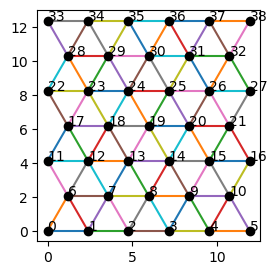

In [10]:
fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111, aspect=1.0)

plt.scatter(aa[:, 0], aa[:, 1], zorder=10, color='black')
for i in range(len(aa)):
    plt.text(aa[i,0], aa[i,1], i)
    
for i in bb:
    plt.plot([(aa[i[0]])[0], (aa[i[1]])[0]], [(aa[i[0]])[1], (aa[i[1]])[1]])

Smash the network

In [11]:
ncts = len(aa)
nnode = 6
aa[:,0] = aa[:,0] - np.mean(aa[:,0])
aa[:,1] = aa[:,1] - np.mean(aa[:,1])
centers = aa

In [12]:
Ang = np.arcsin(2*3**0.5*magr/((l0+2*magr)**2+12*magr**2)**0.5) 

scalewidth = 1.05 # use slightly larger magnet radius in the func. regular_polygon to avoid initial collision
mags_pos, mags_arr = regular_polygon(nnode, magr*scalewidth, centers[0], -np.pi/3+Ang)

for pts in centers[1:]:
    Paa, Pbb = regular_polygon(nnode, magr*scalewidth, pts, -np.pi/3+Ang)
    
    mags_pos = np.vstack([mags_pos, Paa]) # cm 
    mags_arr = np.vstack([mags_arr, Pbb])

In [13]:
# pts index, polygon index, relative postion of pts in belonging polygons
conn_temp_info = np.vstack([np.arange(ncts*nnode), (np.arange(ncts)).repeat(nnode), np.array([np.arange(nnode)]*ncts).flatten()]).T
conn_rela_dic = {0:3, 1:4, 2:5, 3:0, 4:1, 5:2}

conn = []
rtol = 0.02 # this tolerance should change with mag-mag spacing determined by regular_polygon
for thisconn in bb:
    conna = conn_temp_info[np.where(conn_temp_info[:,1]==thisconn[0])]
    connb = conn_temp_info[np.where(conn_temp_info[:,1]==thisconn[1])]
    for i in range(nnode):
        pta = conna[i][0]
        ptb = connb[np.where(connb[:,2]==conn_rela_dic[conna[:, 2][i]])][0,0]
        if np.abs(np.linalg.norm(mags_pos[pta]-mags_pos[ptb])-l0)<rtol:
            conn.append(np.array([pta,ptb]))
            continue
            
conn = np.array(conn)

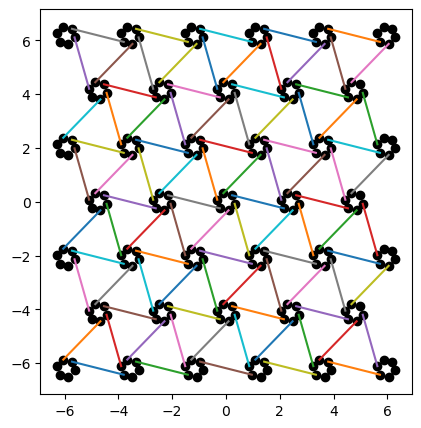

In [14]:
fig = plt.figure(figsize=[5,5])
ax = fig.add_subplot(111, aspect=1.0)

plt.scatter(mags_pos[:, 0], mags_pos[:, 1], color='black')

for i in conn:
    plt.plot([(mags_pos[i[0]])[0], (mags_pos[i[1]])[0]], [(mags_pos[i[0]])[1], (mags_pos[i[1]])[1]])

Save perfect network data file.

In [15]:
# adjagency
adj = np.zeros([len(mags_pos),len(mags_pos)])
for pair in conn:
    adj[pair[0], pair[1]] = 1
    adj[pair[1], pair[0]] = 1

# edge list
smashed_edge_df = net.get_edges2D(adj, mags_pos, stiff=ks)
smashed_edge_dict = net.get_edge_dict(smashed_edge_df.reset_index().set_index('index'))

In [16]:
origin_net_info = {}
origin_net_info['connec'] = conn
origin_net_info['points'] = mags_pos
mags_phis = np.arctan2(mags_arr[:,1], mags_arr[:,0])
origin_net_info['rots'] = mags_phis
origin_net_info['df'] = smashed_edge_df

In [17]:
smashed_edge_df

,edge,i,j,bx,by,k,d
index,,,,,,,
0,"[0, 9]",0.0,9.0,0.969689,-0.244342,0.0,1.984316
1,"[1, 40]",1.0,40.0,0.696451,0.717604,0.0,1.984316
2,"[6, 15]",6.0,15.0,0.969689,-0.244342,0.0,1.984316
3,"[7, 46]",7.0,46.0,0.696451,0.717604,0.0,1.984316
4,"[8, 41]",8.0,41.0,-0.273238,0.961946,0.0,1.984316
...,...,...,...,...,...,...,...
87,"[198, 207]",198.0,207.0,0.969689,-0.244342,0.0,1.984316
88,"[204, 213]",204.0,213.0,0.969689,-0.244342,0.0,1.984316
89,"[210, 219]",210.0,219.0,0.969689,-0.244342,0.0,1.984316


In [18]:
mags_pos = np.hstack([mags_pos, np.zeros([len(mags_pos),1])])
magrs = np.array([magr]*len(mags_pos))
tms = np.array([tm]*len(mags_pos))
Brs = np.array([Br]*len(mags_pos))

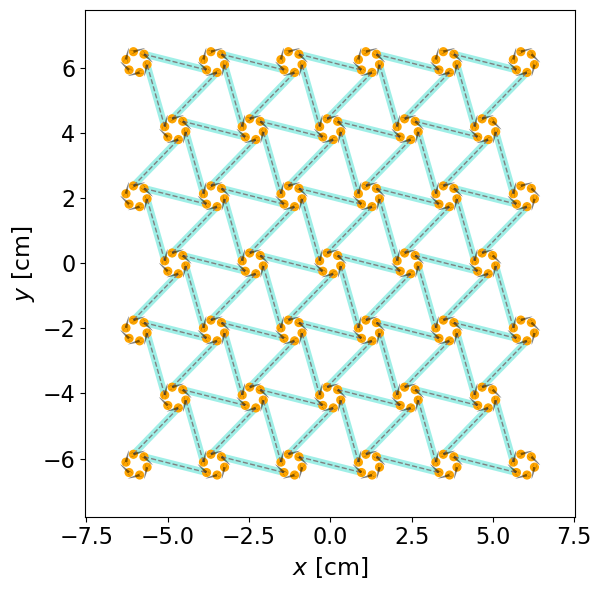

In [19]:
fixedend_sys_funcs.plot_multi_discs(mags_pos, mags_phis, magrs, conn, circlescale=0.75, shiftscale=0.1, 
                               wbold=5, size=[6,6], arrowlw=1.5, arrowscale=40.0, arrowheadwidth=0.2, 
                               arrowheadlength=.5, arrowalpha=0.5, shownodenum=False, nodesize=0)
# plt.savefig(f'origin_net_info-rand.png', dpi=200)

In [20]:
pkl.dump(origin_net_info, open(f'origin_net_info', 'wb'))

Remove unconnected magnets on the boundary (cut).

In [21]:
innernodes = []
for i in range(len(mags_pos)):
    if i in conn.flatten():
        innernodes.append(i)
innernodes = np.array(innernodes)

newmatch = np.vstack([innernodes, np.arange(len(innernodes))]).T
newmatchdic = {}
for i in newmatch:
    newmatchdic[i[0]] = i[1]

conn_cut = []
for thisconn in conn:
    conn_cut.append([newmatchdic[thisconn[0]], newmatchdic[thisconn[1]]])
conn_cut = np.array(conn_cut)

mags_arr_cut = mags_arr[innernodes]
mags_pos_cut = mags_pos[:,:2][innernodes]

In [22]:
def get_edges2D(adj, points, stiff=1):
    """build edgelist"""
    num_edges = int(np.sum(adj) / 2)
    num_pts = np.shape(adj)[0]
    edge_df = pd.DataFrame(data=np.zeros([num_edges,7]),
                           index=np.arange(num_edges),
                           columns=['edge', 'i', 'j', 'bx', 'by', 'k', 'd'])
    edge_df.index.name = 'index'
    edge_ctr = 0
    for i in range(num_pts):
        for j in range(i+1, num_pts):
            if adj[i, j] > 0:
                edge_df.loc[edge_ctr, 'edge'] = str([i, j])
                edge_df.loc[edge_ctr, ['i', 'j']] = i, j
                #b = points[i, :] - points[j, :]
                b = points[j, :] - points[i, :]
                b = b / np.linalg.norm(b)
                edge_df.loc[edge_ctr, ['bx', 'by']] = b
                edge_df.loc[edge_ctr, 'k'] = stiff
                dist = np.linalg.norm(points[i, :] - points[j, :])
                edge_df.loc[edge_ctr, 'd'] = dist
                edge_ctr += 1
    return edge_df

In [23]:
# adjagency
adj = np.zeros([len(mags_pos_cut),len(mags_pos_cut)])
for pair in conn_cut:
    adj[pair[0], pair[1]] = 1
    adj[pair[1], pair[0]] = 1

# edge list
smashed_edge_df = net.get_edges2D(adj, mags_pos_cut, stiff=ks)
smashed_edge_dict = net.get_edge_dict(smashed_edge_df.reset_index().set_index('index'))

In [24]:
origin_net_info = {}
origin_net_info['connec'] = conn_cut
origin_net_info['points'] = mags_pos_cut
mags_phis = np.arctan2(mags_arr_cut[:,1], mags_arr_cut[:,0])
origin_net_info['rots'] = mags_phis
origin_net_info['df'] = smashed_edge_df

In [25]:
smashed_edge_df

,edge,i,j,bx,by,k,d
index,,,,,,,
0,"[0, 5]",0.0,5.0,0.969689,-0.244342,0.0,1.984316
1,"[1, 23]",1.0,23.0,0.696451,0.717604,0.0,1.984316
2,"[2, 9]",2.0,9.0,0.969689,-0.244342,0.0,1.984316
3,"[3, 29]",3.0,29.0,0.696451,0.717604,0.0,1.984316
4,"[4, 24]",4.0,24.0,-0.273238,0.961946,0.0,1.984316
...,...,...,...,...,...,...,...
87,"[164, 167]",164.0,167.0,0.969689,-0.244342,0.0,1.984316
88,"[166, 171]",166.0,171.0,0.969689,-0.244342,0.0,1.984316
89,"[170, 175]",170.0,175.0,0.969689,-0.244342,0.0,1.984316


In [26]:
mags_pos = np.hstack([mags_pos_cut, np.zeros([len(mags_pos_cut),1])])
magrs = np.array([magr]*len(mags_pos_cut))
tms = np.array([tm]*len(mags_pos_cut))
Brs = np.array([Br]*len(mags_pos_cut))

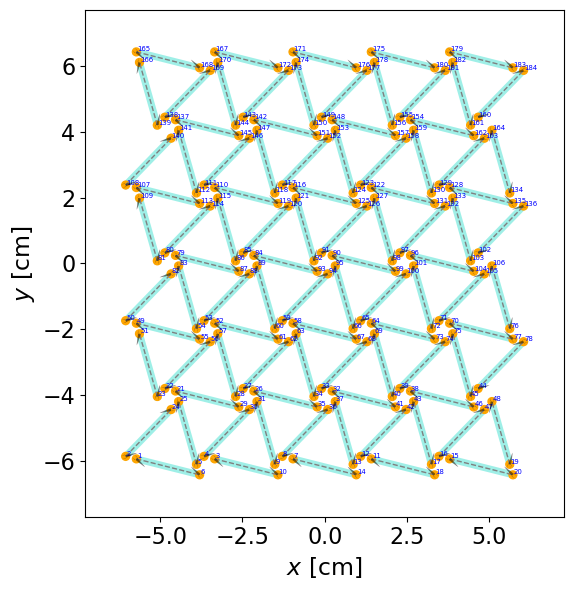

In [27]:
fixedend_sys_funcs.plot_multi_discs(mags_pos, mags_phis, magrs, conn_cut, circlescale=0.75, shiftscale=0.1, wbold=5,
                               size=[6,6],arrowlw=1.5, arrowscale=40.0, arrowheadwidth=0.2, arrowheadlength=.5, 
                               arrowalpha=0.5, shownodenum=True, nodesize=0, nodefontsize=5)
# plt.savefig(f'origin_net_info-perfect-cut.png', dpi=200)

In [28]:
pkl.dump(origin_net_info, open(f'origin_net_info', 'wb'))

In [29]:
origin_net_info['df']

,edge,i,j,bx,by,k,d
index,,,,,,,
0,"[0, 5]",0.0,5.0,0.969689,-0.244342,0.0,1.984316
1,"[1, 23]",1.0,23.0,0.696451,0.717604,0.0,1.984316
2,"[2, 9]",2.0,9.0,0.969689,-0.244342,0.0,1.984316
3,"[3, 29]",3.0,29.0,0.696451,0.717604,0.0,1.984316
4,"[4, 24]",4.0,24.0,-0.273238,0.961946,0.0,1.984316
...,...,...,...,...,...,...,...
87,"[164, 167]",164.0,167.0,0.969689,-0.244342,0.0,1.984316
88,"[166, 171]",166.0,171.0,0.969689,-0.244342,0.0,1.984316
89,"[170, 175]",170.0,175.0,0.969689,-0.244342,0.0,1.984316


Read a saved network.

In [30]:
origin_net_info = pkl.load(open(f'origin_net_info', 'rb'))

In [31]:
magr = 1/16*2.54 # 1/16 inch magnet (cm)
lo = 2.0 # spring initial length (cm)
netlen = lo + 2*magr*0
tm = 1/4*25.4   # in mm
mag_mass = 0.377/1000  # in kg (from K&J magnet spec.s)

# assign magnetic dipole moment magnitude/strength to selected nodes
mu0 = 4*np.pi*1e-7    # permeability of vacuum (H/m), H = J/A2
Br = 1.31 # in T (~N42)
M = Br/mu0    # magnetization (A/m)
# magnet shape (assume height and width are both 1/16 in.)
Rm = magr*10    # in mm

V = (tm/1000)*np.pi*(Rm/1000)**2    # bar magnet volume (m3)
mag_amp = M*V  # magnet moment (A*m2)  
# moment of inertia of cylinder: I = 1/2*m*R^2
mag_J = 0.5*mag_mass*(magr/100)**2 # in kg*m^2

In [32]:
conn = origin_net_info['connec']
rots = origin_net_info['rots']
poss = np.hstack([origin_net_info['points'], np.zeros([len(rots),1])])

lo = origin_net_info['df'][['d']].to_numpy().astype(float)
magrs = np.array([magr]*len(poss))
tms = np.array([tm]*len(poss))
Brs = np.array([Br]*len(poss))

In [33]:
lo

array([[1.98431551],
       [1.98431551],
       [1.98431551],
       [1.98431551],
       [1.98431551],
       [1.98431551],
       [1.98431551],
       [1.98431551],
       [1.98431551],
       [1.98431551],
       [1.98431551],
       [1.98431551],
       [1.98431551],
       [1.98431551],
       [1.98431551],
       [1.98431551],
       [1.98431551],
       [1.98431551],
       [1.98431551],
       [1.98431551],
       [1.98431551],
       [1.98431551],
       [1.98431551],
       [1.98431551],
       [1.98431551],
       [1.98431551],
       [1.98431551],
       [1.98431551],
       [1.98431551],
       [1.98431551],
       [1.98431551],
       [1.98431551],
       [1.98431551],
       [1.98431551],
       [1.98431551],
       [1.98431551],
       [1.98431551],
       [1.98431551],
       [1.98431551],
       [1.98431551],
       [1.98431551],
       [1.98431551],
       [1.98431551],
       [1.98431551],
       [1.98431551],
       [1.98431551],
       [1.98431551],
       [1.984

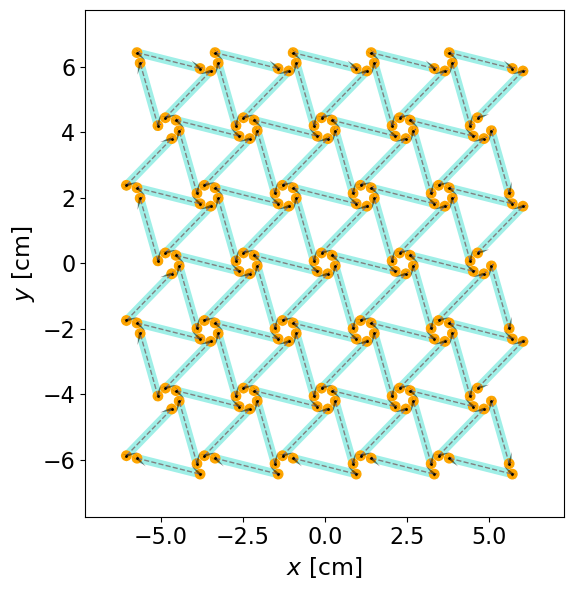

In [34]:
fixedend_sys_funcs.plot_multi_discs(poss, rots, magrs, conn, circlescale=0.9, shiftscale=0.1, wbold=6, 
                                         size=[6,6], arrowlw=2, arrowscale=40.0, arrowheadwidth=0.5, 
                                         arrowheadlength=2, arrowalpha=0.5, shownodenum=True, nodesize=1.0,
                                         nodefontsize=0.)

plt.savefig(f'origin_net_info-perfect.png', dpi=200)

## Energy check before equilibration run

In [35]:
test_sys = fixedend_sys_funcs.multi_disc_system(magrs, tms/10, Brs, rots, poss, conn, lo, eps=3e-2*20.0, 
                                                k=10000, dc=magr*2, krep=50000, kang=1000.0)

In [36]:
np.shape(poss)

(184, 3)

In [37]:
test_sys.Energy_decomp(np.zeros([len(magrs),3]))

Total: -2.036e+00, magnetic: -2.428e+00, elastic:1.156e-29, magnet-magnet LJ repulsion: 0.000e+00,  bond-magnet el repulsion: 3.924e-01, angle energy: 0.000e+00


(-2.0356457671260038,
 -2.4280275937601727,
 1.1555579666323415e-29,
 0,
 0.3923818266341689,
 0.0)

## Recenter and rotate after equilibration run.

We need to recenter and rotate equilibrated perfect lattice to remove regid body motion (translation and rotation).

In [38]:
def recenter_rotate(eq_coor, conn, phi):
    out_coor = eq_coor[:,:2].copy()
    eq_coor_center = np.array([np.mean(out_coor[:,0]), np.mean(out_coor[:,1])]) 
    out_coor = out_coor - eq_coor_center
    rotmat = np.array([[np.cos(phi), -np.sin(phi)],[np.sin(phi), np.cos(phi)]])
    out_coor = out_coor@rotmat
    end_rot = eq_coor[:,2] - phi
    out_coor = np.hstack([out_coor, end_rot.reshape([len(end_rot),1])])
    return out_coor

In [39]:
def relative_angle(udofs,mag_phis):

    rot_re = np.zeros(np.shape(mag_phis))
    for thisconn in conn:
        temp = np.array(poss)[thisconn[1]] - np.array(poss)[thisconn[0]]
        temp = temp[:2]/np.linalg.norm(temp[:2])
        thisrot = np.arctan2(temp[1], temp[0])
        rot_re[thisconn[1]] = mag_phis[thisconn[1]] - thisrot
        rot_re[thisconn[0]] = mag_phis[thisconn[0]] - thisrot
            
    udofs_arr = udofs.reshape([len(poss), 3])
    udofs_rot = udofs_arr[:, -1]
    udofs_xyz = udofs_arr[:,:-1]
    udofs_xyz = np.hstack([udofs_xyz, np.zeros([len(poss),1])])
    new_poss = np.array(poss) + udofs_xyz
    new_rots = mag_phis + udofs_rot

    conn_dic = {}
    for jj in range(len(poss)//2):
        conn_dic[conn[jj][0]] = jj
        conn_dic[conn[jj][1]] = jj
    
    # calculate new rotation of springs 
    newsrot_spring = []
    for thisconn in conn:
        temp = new_poss[thisconn[1]] - new_poss[thisconn[0]]
        temp = temp/np.linalg.norm(temp)
        newsrot_spring.append(np.arctan2(temp[1], temp[0]))
    newsrot_spring = np.array(newsrot_spring)

    # relative angle between the spring and the magnetic dipole
    newrot_re = np.array([new_rots[nn] - newsrot_spring[conn_dic[nn]] for nn in range(len(poss))])
    # convert to [-pi, pi] 
    newrot_re = np.arctan2(np.sin(newrot_re), np.cos(newrot_re))
    temp2 = newrot_re - rot_re
    temp2 = np.arctan2(np.sin(temp2), np.cos(temp2))

    return temp2 

In [40]:
origin_net_info = pkl.load(open(f'origin_net_info', 'rb'))

In [41]:
# for thisBr in [1.19, 1.23, 1.27, 1.31, 1.35, 1.39, 1.43, 1.47]:
for thisBr in [1.31]:

    magr = 1/16*2.54 # 1/16 inch magnet (cm)
    lo = 2.0 # spring initial length (cm)
    tm = 0.25*25.4   # in mm
    mag_mass = 0.377/1000  # in kg (from K&J magnet spec.s)
    
    netlen = lo + 2*magr*0
    # assign magnetic dipole moment magnitude/strength to selected nodes
    mu0 = 4*np.pi*1e-7    # permeability of vacuum (H/m), H = J/A2
    Br = float(thisBr) # in T (~N42)
    M = Br/mu0    # magnetization (A/m)
    # magnet shape (assume height and width are both 1/16 in.)
    Rm = magr*10    # in mm
    V = (tm/1000)*np.pi*(Rm/1000)**2    # bar magnet volume (m3)
    mag_amp = M*V  # magnet moment (A*m2)  
    # moment of inertia of cylinder: I = 1/2*m*R^2
    mag_J = 0.5*mag_mass*(magr/100)**2 # in kg*m^2

    origin_net_info = pkl.load(open(f'origin_net_info', 'rb'))
    conn = origin_net_info['connec']
    rots = origin_net_info['rots']
    poss = np.hstack([origin_net_info['points'], np.zeros([len(rots),1])])

    lo = origin_net_info['df'][['d']].to_numpy().astype(float)
    magrs = np.array([magr]*len(poss))
    tms = np.array([tm]*len(poss))
    Brs = np.array([Br]*len(poss))

    ini_poss = poss.copy() # otherwise poss would be modified
    ini_poss[:,0] *= 0.01
    ini_poss[:,1] *= 0.01
    ini_poss[:,2] = rots

    u_traj = pkl.load(open(f'eq-0/dic_in_process','rb'))['u']+ini_poss.flatten()
    eq_poss = u_traj[-1].reshape([len(poss),3]) # m,m, rad

    uhis = pkl.load(open(f'eq-0/dic_in_process','rb'))['u']*np.array([100, 100, 1]*len(poss))

    ## check Bond change
    bond_length_his = np.array([np.linalg.norm(((u_traj[nofr].reshape(len(poss),3)*100)[conn[:,1]] - (u_traj[nofr].reshape(len(poss),3)*100)[conn[:,0]])[:,:2], axis=1) for nofr in range(len(u_traj))])
    bond_length_change_his = (bond_length_his-bond_length_his[0])/bond_length_his[0]*100
    # bond_length_change_his = (bond_length_his-2)/2*100
    fig = plt.figure(figsize=[8,3.5])
    ax = fig.add_subplot(1,1,1)
    # array number grows in a way opposite to the Cartesian coordiante, np.filpud makes them grow in the same way
    plt.imshow(bond_length_change_his.T,  aspect='auto', cmap='bwr', 
               vmax=max([np.max(bond_length_change_his), -np.min(bond_length_change_his)]), 
               vmin=-max([np.max(bond_length_change_his), -np.min(bond_length_change_his)]))
    plt.colorbar(fraction=0.046, pad=0.04, label='bond change (%)')
    plt.title('Bond Length Change History')
    plt.xlabel('frame No.')
    plt.ylabel('bond No.')
    plt.tight_layout()
    plt.savefig(f'{pathpre}/bond_change.png', dpi=200)
    plt.close()

    clusterA = eq_poss[[57, 58, 59, 60, 61, 62]]
    clusterB = eq_poss[[63, 64, 65, 66, 67, 68]]
    centerA = np.array([np.mean(clusterA[:,0]), np.mean(clusterA[:,1])])
    centerB = np.array([np.mean(clusterB[:,0]), np.mean(clusterB[:,1])])
    cAB = centerB-centerA
    rotAB = np.arctan2(cAB[1], cAB[0])

    out_pos = recenter_rotate(eq_poss, conn, rotAB)
#     out_pos = eq_poss.copy()
    fixedend_sys_funcs.plot_multi_discs(out_pos*100, out_pos[:,-1], magrs, conn, circlescale=0.75, shiftscale=0.1, 
                                   wbold=5, size=[6,6], arrowlw=1.5, arrowscale=40.0, arrowheadwidth=0.2, 
                                   arrowheadlength=.5, arrowalpha=0.5, shownodenum=True, nodesize=4,
                                   nodefontsize=7)

    plt.savefig(f'final.png', dpi=200)
    plt.close()

    origin_net_info['points'] = out_pos[:,:2]*100
    origin_net_info['rots'] = out_pos[:,2]

    # adjagency
    adj = np.zeros([len(out_pos),len(out_pos)])
    for pair in conn:
        adj[pair[0], pair[1]] = 1
        adj[pair[1], pair[0]] = 1

    # edge list
    smashed_edge_df = net.get_edges2D(adj, out_pos[:,:2]*100, stiff=ks)
    smashed_edge_dict = net.get_edge_dict(smashed_edge_df.reset_index().set_index('index'))

    origin_net_info['df'] = smashed_edge_df

    pkl.dump(origin_net_info, open(f'origin_net_info-perfect-eq', 'wb'))

FileNotFoundError: [Errno 2] No such file or directory: 'eq-0/dic_in_process'

Check rotated config.

In [ ]:
# for thisBr in [1.19, 1.23, 1.27, 1.31, 1.35, 1.39, 1.43, 1.47]:
for thisBr in [1.31]:

    magr = 1/16*2.54 # 1/16 inch magnet (cm)
    lo = 2.0 # spring initial length (cm)
    netlen = lo + 2*magr*0

    # assign magnetic dipole moment magnitude/strength to selected nodes
    mu0 = 4*np.pi*1e-7    # permeability of vacuum (H/m), H = J/A2
    Br = float(thisBr) # in T (~N42)
    M = Br/mu0    # magnetization (A/m)
    # magnet shape (assume height and width are both 1/16 in.)
    Rm = magr*10    # in mm
    tm = 0.25*25.4   # in mm
    V = (tm/1000)*np.pi*(Rm/1000)**2    # bar magnet volume (m3)
    mag_amp = M*V  # magnet moment (A*m2)  
    mag_mass = 0.377/1000  # in kg (from K&J magnet spec.s)
    # moment of inertia of cylinder: I = 1/2*m*R^2
    mag_J = 0.5*mag_mass*(magr/100)**2 # in kg*m^2

    origin_net_info = pkl.load(open(f'origin_net_info-perfect-eq', 'rb'))
    conn = origin_net_info['connec']
    rots = origin_net_info['rots']
    poss = np.hstack([origin_net_info['points'], np.zeros([len(rots),1])])

    lo = origin_net_info['df'][['d']].to_numpy().astype(float)
    magrs = np.array([magr]*len(poss))
    tms = np.array([tm]*len(poss))
    Brs = np.array([Br]*len(poss))

    ini_poss = poss.copy() # otherwise poss would be modified
    ini_poss[:,0] *= 0.01
    ini_poss[:,1] *= 0.01
    ini_poss[:,2] = rots
    
    fixedend_sys_funcs.plot_multi_discs(ini_poss*100, ini_poss[:,-1], magrs, conn, circlescale=1.5, shiftscale=0.1, 
                                   wbold=5, size=[6,6], arrowlw=1.5, arrowscale=40.0, arrowheadwidth=0.2, 
                                   arrowheadlength=.5, arrowalpha=0.5, shownodenum=True, nodesize=4,
                                   nodefontsize=7)

    plt.savefig(f'final-eq.png', dpi=200)
    plt.close()